In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\Thuc-hanh\\Lab 4\\fpt_data_sheet.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume','ticker'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [2]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [3]:
# 4. Chia train test (70% train, 30% test)
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [4]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 9s 172ms/step - loss: 0.0357 - val_loss: 0.0472
Epoch 2/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 3/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/100
14/14 [==============================] - 1s 51ms/step - loss: 9.7250e-04 - val_loss: 0.0022
Epoch 5/100
14/14 [==============================] - 1s 52ms/step - loss: 8.0691e-04 - val_loss: 0.0023
Epoch 6/100
14/14 [==============================] - 1s 55ms/step - loss: 8.1106e-04 - val_loss: 0.0025
Epoch 7/100
14/14 [==============================] - 1s 54ms/step - loss: 7.1736e-04 - val_loss: 0.0032
Epoch 8/100
14/14 [==============================] - 1s 56ms/step - loss: 7.1437e-04 - val_loss: 0.0029
Epoch 9/100
14/14 [==============================] - 1s 52ms/step - loss: 7.2994e-04 - val_loss: 0.0036
Epoch 10/100
14/14 [==============================] - 1s 53ms/step - loss: 

In [9]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

11/11 [==============================] - 2s 11ms/step


In [10]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [11]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 3096.390045934269
MAPE trên tập test là: 2.7475088553534537 %
MSLE trên tập test là: 0.001246082225774487


In [12]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

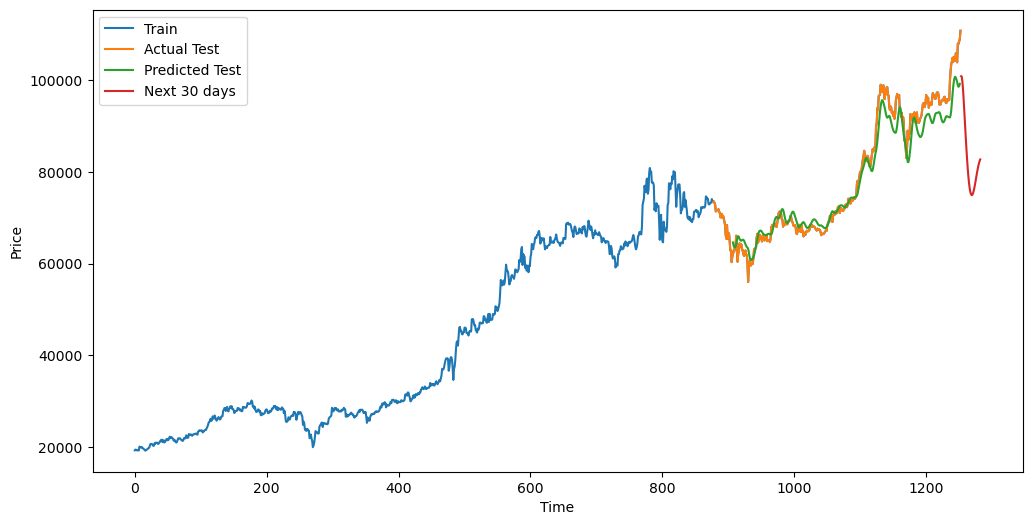

In [13]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 8/2)

In [14]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\Thuc-hanh\\Lab 4\\fpt_data_sheet.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume','ticker'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [15]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [16]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [17]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 [==============================] - 10s 143ms/step - loss: 0.0376 - val_loss: 0.0740
Epoch 2/100
16/16 [==============================] - 1s 42ms/step - loss: 0.0054 - val_loss: 0.0114
Epoch 3/100
16/16 [==============================] - 1s 41ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 4/100
16/16 [==============================] - 1s 41ms/step - loss: 8.7385e-04 - val_loss: 0.0058
Epoch 5/100
16/16 [==============================] - 1s 42ms/step - loss: 7.5365e-04 - val_loss: 0.0055
Epoch 6/100
16/16 [==============================] - 1s 41ms/step - loss: 7.5212e-04 - val_loss: 0.0054
Epoch 7/100
16/16 [==============================] - 1s 41ms/step - loss: 7.2147e-04 - val_loss: 0.0057
Epoch 8/100
16/16 [==============================] - 1s 40ms/step - loss: 7.0068e-04 - val_loss: 0.0050
Epoch 9/100
16/16 [==============================] - 1s 41ms/step - loss: 7.0691e-04 - val_loss: 0.0060
Epoch 10/100
16/16 [==============================] - 1s 41ms/step - loss:

In [22]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

7/7 [==============================] - 2s 10ms/step


In [23]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 4524.789514248941
MAPE trên tập test là: 4.131064562987323 %
MSLE trên tập test là: 0.0024351010391185945


In [25]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

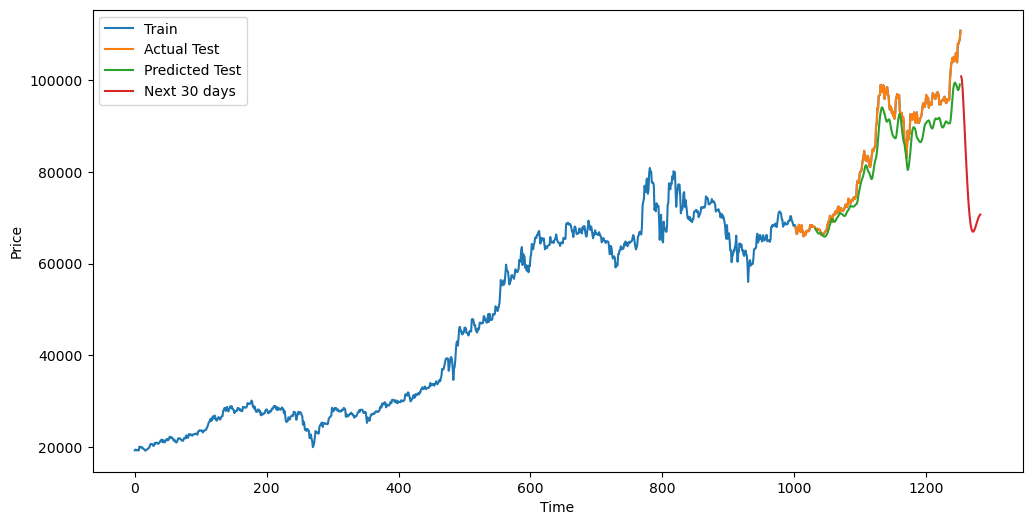

In [26]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 9/1)

In [27]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\Thuc-hanh\\Lab 4\\fpt_data_sheet.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume','ticker'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [28]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [29]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [30]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [32]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [33]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
18/18 [==============================] - 10s 127ms/step - loss: 0.0229 - val_loss: 0.0261
Epoch 2/100
18/18 [==============================] - 1s 38ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 4/100
18/18 [==============================] - 1s 38ms/step - loss: 8.4429e-04 - val_loss: 0.0078
Epoch 5/100
18/18 [==============================] - 1s 38ms/step - loss: 8.0291e-04 - val_loss: 0.0074
Epoch 6/100
18/18 [==============================] - 1s 38ms/step - loss: 8.2504e-04 - val_loss: 0.0064
Epoch 7/100
18/18 [==============================] - 1s 38ms/step - loss: 8.0564e-04 - val_loss: 0.0076
Epoch 8/100
18/18 [==============================] - 1s 38ms/step - loss: 8.3486e-04 - val_loss: 0.0048
Epoch 9/100
18/18 [==============================] - 1s 39ms/step - loss: 7.7719e-04 - val_loss: 0.0072
Epoch 10/100
18/18 [==============================] - 1s 39ms/step - loss:

In [35]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

3/3 [==============================] - 2s 10ms/step


In [36]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [37]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2562.020257320633
MAPE trên tập test là: 2.1031593147904126 %
MSLE trên tập test là: 0.0007449227477926999


In [38]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

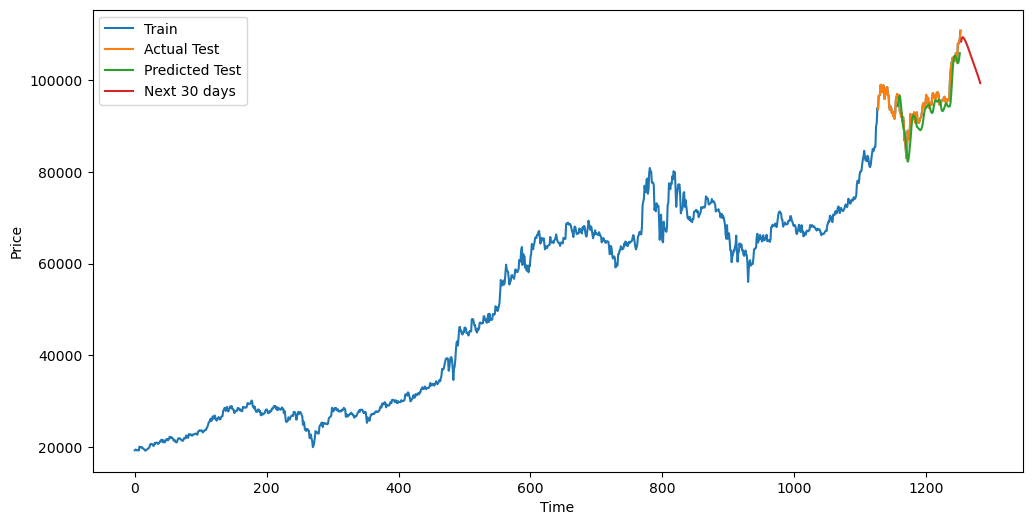

In [39]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()